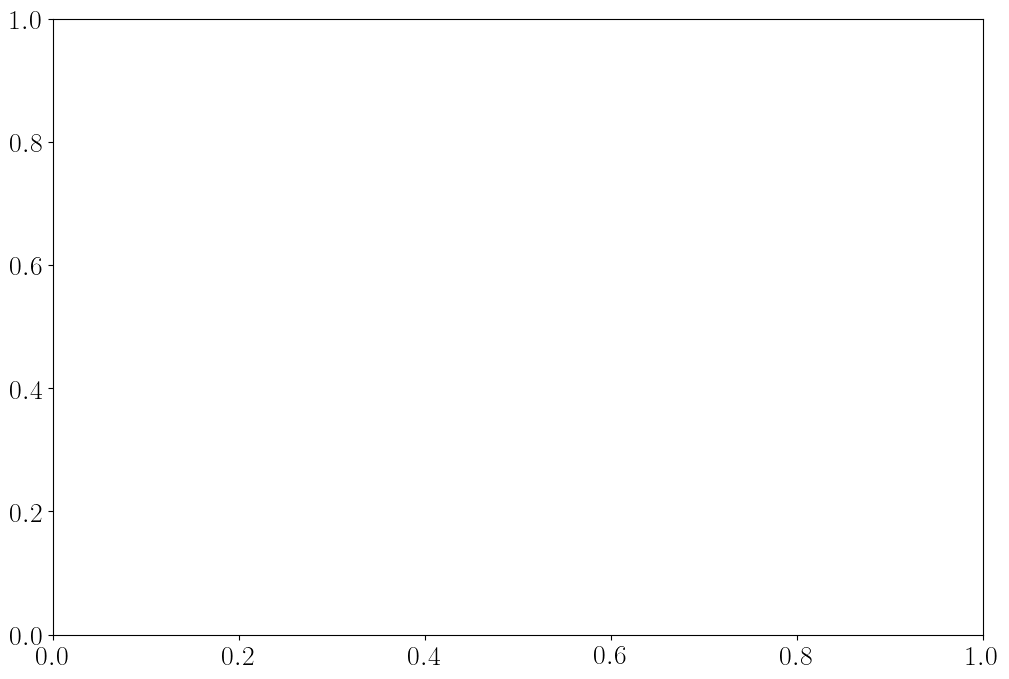

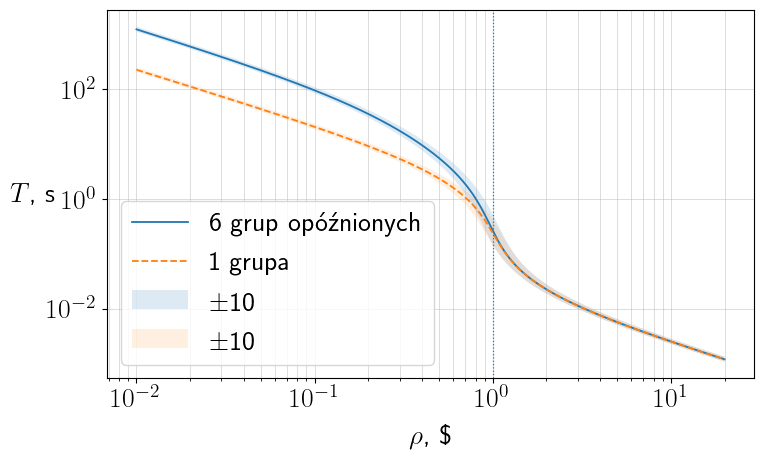

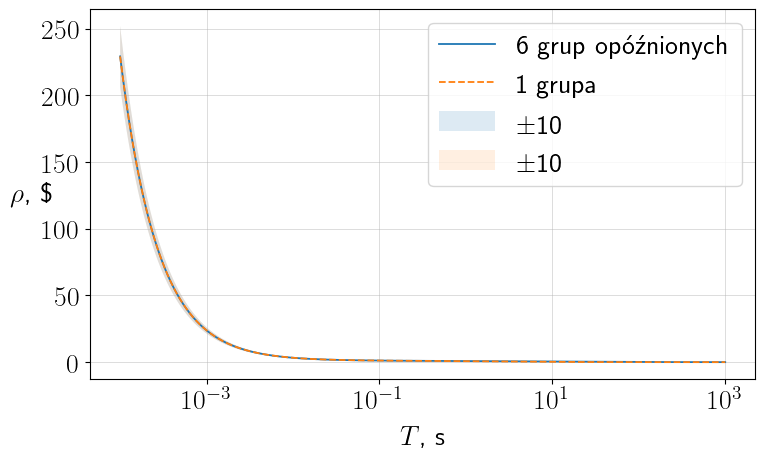

In [3]:
# ========================================================================
# PORÓWNANIE T(ρ) i ρ(T): 1-gr (β1 = sum β_i) vs 6-gr + PAS ±10% ρ
# Wyświetlanie wykresów, etykiety: "ρ, $" i "T, s"
# ========================================================================
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ----------------------- Parametry wspólne -----------------------
Lambda_prompt = 146e-6  # Λ [s]

# ----------------------- Model 6-grupowy -------------------------
beta_i   = np.array([2.43e-4, 1.363e-3, 1.203e-3, 2.605e-3, 8.19e-4, 1.67e-4])
lambda_i = np.array([1.27e-2, 3.17e-2, 1.15e-1, 3.11e-1, 1.40,   3.87   ])  # [1/s]
beta6 = beta_i.sum()  # = 0.006552

def rho_6g(T: np.ndarray) -> np.ndarray:
    """ρ z równania inhour 6-gr (T>0)."""
    T = np.array(T, dtype=float)
    val = Lambda_prompt / T
    for b, lam in zip(beta_i, lambda_i):
        val += b / (1.0 + lam * T)
    return val

def rho_dollar_6g(T: np.ndarray) -> np.ndarray:
    return rho_6g(T) / beta6

# ----------------------- Model 1-grupowy -------------------------
beta1 = beta6
lam1  = 0.44  # [1/s]

def rho_1g(T: np.ndarray) -> np.ndarray:
    T = np.array(T, dtype=float)
    return Lambda_prompt / T + beta1 / (1.0 + lam1 * T)

def rho_dollar_1g(T: np.ndarray) -> np.ndarray:
    return rho_1g(T) / beta1

# ----------------------- Format osi 10^n -------------------------
def set_log_10n(ax, which=("x","y")):
    """Etykiety główne w zapisie 10^n (mathtext) na osiach log."""
    import numpy as np
    for axis in which:
        ax_axis = getattr(ax, f"{axis}axis")
        ax_axis.set_major_locator(ticker.LogLocator(base=10))
        ax_axis.set_major_formatter(ticker.LogFormatterMathtext(base=10))
        ax_axis.set_minor_locator(ticker.LogLocator(base=10, subs=np.arange(2,10)*0.1))
        ax_axis.set_minor_formatter(ticker.NullFormatter())

# ----------------------- Inwersja T(ρ) ---------------------------
def T_of_rho_dollar_1g(r: np.ndarray) -> np.ndarray:
    # r = ρ/β1 = Λ/(β1 T) + 1/(1 + λ1 T)
    A = Lambda_prompt / beta1
    a = r * lam1
    b = (r - 1.0 - A * lam1)
    c = -A
    disc = b*b - 4.0*a*c
    disc = np.maximum(disc, 0.0)
    T = (-b + np.sqrt(disc)) / (2.0 * a)
    return T

def make_T_of_rho_dollar_6g():
    T_grid = np.geomspace(1e-8, 1e5, 300_000)
    r_grid = rho_dollar_6g(T_grid)
    m = np.isfinite(r_grid)
    Tg = T_grid[m]
    rg = r_grid[m]
    order = np.argsort(rg)  # rosnąco po ρ[$]
    return rg[order], Tg[order]

_rg6_sorted, _Tg6_sorted = make_T_of_rho_dollar_6g()

def T_of_rho_dollar_6g(r: np.ndarray) -> np.ndarray:
    return np.interp(r, _rg6_sorted, _Tg6_sorted)

# ----------------------- Niepewność ±10% ρ ----------------------
frac_r = 0.10  # ±10%

def rho_band(r: np.ndarray, frac: float = frac_r):
    r = np.asarray(r, dtype=float)
    return (1.0 - frac) * r, (1.0 + frac) * r

# ----------------------- T(ρ): 0.01–20 $ -------------------------
rho_min, rho_max, N = 0.01, 20.0, 6000
rho_targets = np.geomspace(rho_min, rho_max, N)
T6 = T_of_rho_dollar_6g(rho_targets)
T1 = T_of_rho_dollar_1g(rho_targets)

rho_lo, rho_hi = rho_band(rho_targets)
T6_lo = T_of_rho_dollar_6g(rho_lo); T6_hi = T_of_rho_dollar_6g(rho_hi)
T1_lo = T_of_rho_dollar_1g(rho_lo); T1_hi = T_of_rho_dollar_1g(rho_hi)

# ----------------------- ρ(T): dane do pasów ---------------------
T_plot = np.geomspace(1e-4, 1e3, 100_000)  # 0.1 ms … 1000 s
r6 = rho_dollar_6g(T_plot); r1 = rho_dollar_1g(T_plot)
r6_lo, r6_hi = rho_band(r6); r1_lo, r1_hi = rho_band(r1)

# ----------------------- Wykresy ------------------------------
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams.update({'font.size': 20})
plt.rc('axes', labelsize=20)
plt.rcParams.update({
    'font.size': 20,
    'text.usetex': True,
    'text.latex.preamble': r'''
        \usepackage[bb=boondox]{mathalfa}
        \usepackage[polish]{babel}
        \usepackage[utf8]{inputenc}
        \usepackage{polski}'''
})
# (A) T vs ρ [$]
fig, ax = plt.subplots(figsize=(8,5))
ax.loglog(rho_targets, T6, linewidth=1.3, label="6 grup opóźnionych")
ax.loglog(rho_targets, T1, linewidth=1.3, linestyle="--", label="1 grupa")
ax.fill_between(rho_targets, T6_lo, T6_hi, alpha=0.15, label="±10% ρ — pas (6g)")
ax.fill_between(rho_targets, T1_lo, T1_hi, alpha=0.12, label="±10% ρ — pas (1g)")
ax.axvline(1.0, linestyle=":", linewidth=0.9)

# etykiety: "ρ, $" (x) i "T, s" (y), poziomo
ax.set_xlabel(r"$\rho$, \$", labelpad=8)
ylab = ax.set_ylabel(r"$T$, s", rotation=0, labelpad=25, ha="left", va="center")
ax.yaxis.set_label_coords(-0.15, 0.5)

ax.grid(True, which="both", linewidth=0.5, alpha=0.6)
set_log_10n(ax, which=("x","y"))
ax.legend()
plt.tight_layout()
fig.savefig("/home/piegus/Pictures/T_vs_rho.png", dpi=300)
# (B) ρ [$] vs T
fig2, ax2 = plt.subplots(figsize=(8,5))
ax2.semilogx(T_plot, r6, linewidth=1.3, label="6 grup opóźnionych")
ax2.semilogx(T_plot, r1, linewidth=1.3, linestyle="--", label="1 grupa")
ax2.fill_between(T_plot, r6_lo, r6_hi, alpha=0.15, label="±10% ρ — pas (6g)")
ax2.fill_between(T_plot, r1_lo, r1_hi, alpha=0.12, label="±10% ρ — pas (1g)")

# etykiety: "T, s" (x) i "ρ, $" (y), poziomo
ax2.set_xlabel(r"$T$, s", labelpad=8)
ylab2 = ax2.set_ylabel(r"$\rho$, \$", rotation=0, labelpad=25, ha="left", va="center")
# daj np. tak:
ax2.yaxis.set_label_coords(-0.12, 0.5)


ax2.grid(True, which="both", linewidth=0.5, alpha=0.6)
set_log_10n(ax2, which=("x",))  # tylko oś T w zapisie 10^n
ax2.legend()
plt.tight_layout()
fig2.savefig("/home/piegus/Pictures/T_vs_rho.png", dpi=300)
plt.show()

